In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [2]:
os.chdir("D://SCMA//Data")

In [3]:
data=pd.read_csv("NSSO68 (1).csv",encoding="Latin-1", low_memory=False)

# Filter data for AP


In [4]:
ap_data = data[data['state_1']=="AP"]

# Check for missing values

In [5]:
missing_values = ap_data.isnull().sum()
print("Missing values in each column:")
print(missing_values)

Missing values in each column:
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


# Replace missing values with mean

In [6]:
ap_data = ap_data.apply(lambda x: x.fillna(x.mean()) if x.dtype.kind in 'biufc' else x)

# Verify that there are no more missing values

In [7]:
missing_values_after = ap_data.isna().sum()
print("Missing values after replacement for Ap")
print(missing_values_after)


Missing values after replacement for Ap
slno              0
grp               0
Round_Centre      0
FSU_number        0
Round             0
                 ..
foodtotal_q       0
state_1           0
Region            0
fruits_df_tt_v    0
fv_tot            0
Length: 384, dtype: int64


# Identify and remove outliers using the IQR method

In [8]:
numeric_columns = ap_data.select_dtypes(include=[np.number]).columns
for col in numeric_columns:
    Q1 = ap_data[col].quantile(0.25)
    Q3 = ap_data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((ap_data[col] < (Q1 - 1.5 * IQR)) | (ap_data[col] > (Q3 + 1.5 * IQR)))
    print(f"{col} has {outliers.sum()} outliers in Ap")
    ap_data = ap_data[~outliers]

slno has 0 outliers in Ap
Round_Centre has 0 outliers in Ap
FSU_number has 0 outliers in Ap
Round has 0 outliers in Ap
Schedule_Number has 0 outliers in Ap
Sample has 0 outliers in Ap
Sector has 0 outliers in Ap
state has 0 outliers in Ap
State_Region has 0 outliers in Ap
District has 0 outliers in Ap
Stratum_Number has 0 outliers in Ap
Sub_Stratum has 160 outliers in Ap
Schedule_type has 0 outliers in Ap
Sub_Round has 0 outliers in Ap
Sub_Sample has 0 outliers in Ap
FOD_Sub_Region has 16 outliers in Ap
Hamlet_Group_Sub_Block has 0 outliers in Ap
t has 162 outliers in Ap
X_Stage_Stratum has 0 outliers in Ap
HHS_No has 539 outliers in Ap
Level has 0 outliers in Ap
Filler has 0 outliers in Ap
hhdsz has 93 outliers in Ap
NIC_2008 has 0 outliers in Ap
NCO_2004 has 0 outliers in Ap
HH_type has 502 outliers in Ap
Religion has 626 outliers in Ap
Social_Group has 2185 outliers in Ap
Whether_owns_any_land has 519 outliers in Ap
Type_of_land_owned has 0 outliers in Ap
Land_Owned has 229 outliers

# Check if the column exists and rename it

In [9]:
if 'old_district_column_name' in ap_data.columns:
    ap_data.rename(columns={'old_district_column_name': 'new_district_column_name'}, inplace=True)
else:
    print("Column 'old_district_column_name' doesn't exist in the data.")

Column 'old_district_column_name' doesn't exist in the data.


# Summarize the critical variables region-wise

In [10]:
region_summary = ap_data.groupby('FOD_Sub_Region').agg(
    avg_No_of_Meals_per_day=('No_of_Meals_per_day', 'mean'),
    min_No_of_Meals_per_day=('No_of_Meals_per_day', 'min'),
    max_No_of_Meals_per_day=('No_of_Meals_per_day', 'max')
).reset_index()


# Summarize the critical variables district-wise

In [11]:
district_summary = ap_data.groupby('District').agg(
    avg_No_of_Meals_per_day=('No_of_Meals_per_day', 'mean'),
    min_No_of_Meals_per_day=('No_of_Meals_per_day', 'min'),
    max_No_of_Meals_per_day=('No_of_Meals_per_day', 'max')
).reset_index()

# Mutate the District column

In [12]:
ap_data['District'] = ap_data['District'].apply(lambda x: 'Ap Urban' if x == '18' else x)


# Identify the top and bottom three districts of consumption

In [13]:
top_three_districts = district_summary.sort_values(by='avg_No_of_Meals_per_day', ascending=False).head(3)
bottom_three_districts = district_summary.sort_values(by='avg_No_of_Meals_per_day').head(3)


# Inspect unique values in No_of_Meals_per_day for each District

In [14]:
unique_values_per_district = ap_data.groupby('District')['No_of_Meals_per_day'].unique()
print("Unique values of No_of_Meals_per_day for each District:")
for district, unique_values in unique_values_per_district.items():
    print(f"{district}: {unique_values}")

Unique values of No_of_Meals_per_day for each District:
4: [3.]
11: [3.]
15: [3.]



# ANOVA analysis

In [15]:
import statsmodels.api as sm

In [16]:
from scipy.stats import f_oneway

In [17]:
from statsmodels.formula.api import ols

In [18]:
district_groups = [ap_data[ap_data['District'] == district]['No_of_Meals_per_day'].dropna() for district in ap_data['District'].unique()]
anova_result = f_oneway(*district_groups)

C:\Users\HP\anaconda3\Lib\site-packages\scipy\stats\_stats_py.py:4141: DegenerateDataWarning: all input arrays have length 1.  f_oneway requires that at least one input has length greater than 1.
  warnings.warn(stats.DegenerateDataWarning(msg))


# Display ANOVA results

In [19]:
model = ols('No_of_Meals_per_day ~ (District)', data=ap_data).fit()
anova_result = sm.stats.anova_lm(model, typ=2)

In [20]:
print("ANOVA results:\n")
print(anova_result)

ANOVA results:

                sum_sq   df         F   PR(>F)
District  1.194077e-32  1.0  0.020182  0.91016
Residual  5.916457e-31  1.0       NaN      NaN


In [21]:
anova_summary = anova_result.reset_index()
anova_summary.columns = ['Source', 'sum_sq', 'df', 'F', 'PR(>F)']

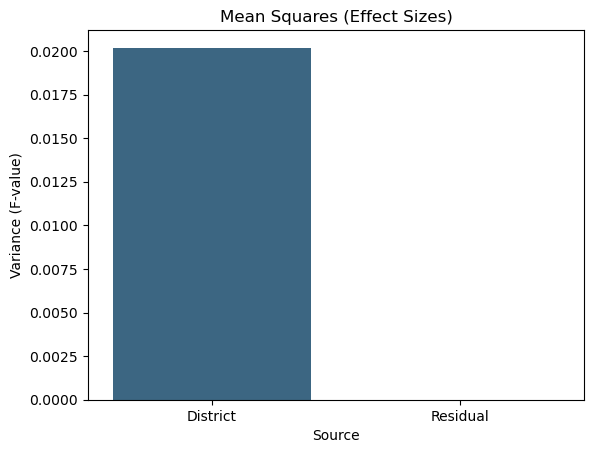

In [22]:
sns.barplot(x='Source', y='F', data=anova_summary, palette='viridis')
plt.title('Mean Squares (Effect Sizes)')
plt.xlabel('Source')
plt.ylabel('Variance (F-value)')
plt.show()

##In conclusion, the ANOVA results suggest that the District variable does not have a significant effect on the mean of No_of_Meals_per_day.

# Multiple Regression Analysis

In [23]:
import statsmodels.api as sm

# Define the dependent and independent variables

In [24]:
y = ap_data['No_of_Meals_per_day']
X = ap_data[['Region', 'District', 'FOD_Sub_Region', 'foodtotal_q', 'fv_tot']]


# Add a constant to the independent variables

In [25]:
X = sm.add_constant(X)

# Fit the multiple regression model

In [26]:
model = sm.OLS(y, X).fit()

# Print the regression summary

In [27]:
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     No_of_Meals_per_day   R-squared:                        -inf
Model:                             OLS   Adj. R-squared:                   -inf
Method:                  Least Squares   F-statistic:                       nan
Date:                 Sun, 23 Jun 2024   Prob (F-statistic):                nan
Time:                         15:11:32   Log-Likelihood:                 103.44
No. Observations:                    3   AIC:                            -200.9
Df Residuals:                        0   BIC:                            -203.6
Df Model:                            2                                         
Covariance Type:             nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           7.003e-07        i

C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1794: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1716: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid


# Regression Diagnostics

### 1. Linearity

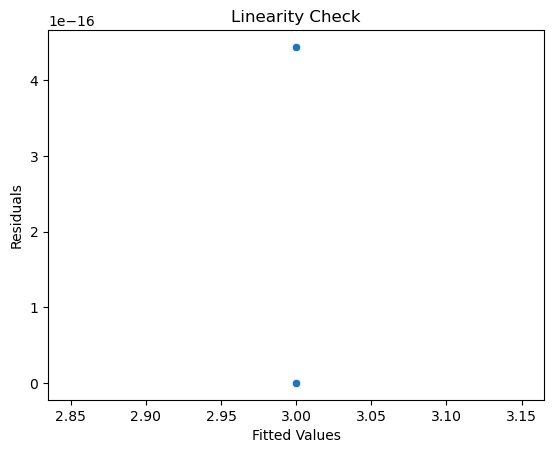

In [28]:
sns.scatterplot(x=model.fittedvalues, y=model.resid)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Linearity Check')
plt.show()

### 2. Homoscedasticity

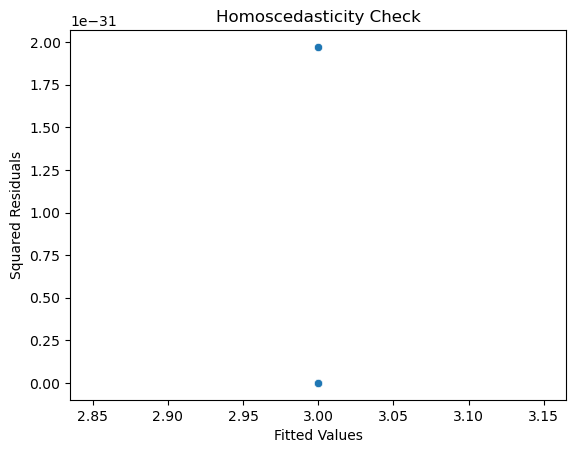

In [29]:
sns.scatterplot(x=model.fittedvalues, y=model.resid**2)
plt.xlabel('Fitted Values')
plt.ylabel('Squared Residuals')
plt.title('Homoscedasticity Check')
plt.show()

### 3. Normality of Residuals

C:\Users\HP\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


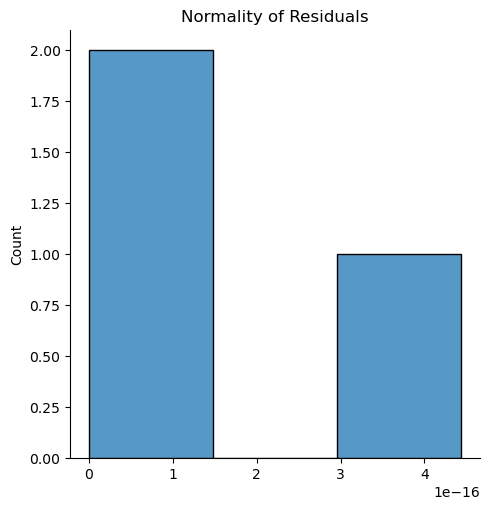

In [30]:
sns.displot(model.resid, kde=False)
plt.title('Normality of Residuals')
plt.show()

### 4. Multicollinearity

In [31]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['features'] = X.columns
print(vif)

   VIF        features
0  0.0           const
1  inf          Region
2  inf        District
3  inf  FOD_Sub_Region
4  inf     foodtotal_q
5  inf          fv_tot


C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\regression\linear_model.py:1781: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\HP\anaconda3\Lib\site-packages\statsmodels\stats\outliers_influence.py:198: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


### 5. Autocorrelation

In [32]:
from statsmodels.stats.stattools import durbin_watson
dw_stat = durbin_watson(model.resid)
print(f'Durbin-Watson statistic: {dw_stat}')

Durbin-Watson statistic: 1.0
